In [ ]:
!pip install opendatasets
!pip install Pillow
!pip install opencv-python
!pip install keras
!pip install torchvision

In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from google.colab import drive
import cv2
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import opendatasets as od
from PIL import Image

In [ ]:
# downloading dataset
od.download(
	"https://www.kaggle.com/datasets/archijain916/cervical-cancer")
file_path = '/content/data.csv'

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: archijain916
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/archijain916/cervical-cancer


100%|██████████| 553M/553M [00:08<00:00, 72.2MB/s]


In [ ]:
#image dimensions
img_rows = 224
img_cols = 224
channels = 1
img_shape = (img_rows, img_cols, channels)

In [ ]:
# Define the shape of the input noise vector
noise_shape = (100,)

# building genrator network
def build_generator():
    model = Sequential()

    model.add(Dense(512, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    # Call the model on a batch of data to build it
    model(np.random.randn(1, *noise_shape))

    # Print model summary
    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)
    return Model(noise, img)

In [ ]:
# Building Discrinator Network
def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [ ]:
# Concatenate images into a numpy array for training
def read_and_append_images(folder_path):
    # list of all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.png') or f.endswith('.jpg')]

    image_files.sort()

    # Initialize an empty list to store the image data
    images_data = []

    # Iterate over each image file
    for image_file in image_files:
        # Construct the full path to the image file
        image_path = os.path.join(folder_path, image_file)

        # Reading the image file using TensorFlow
        image = tf.io.read_file(image_path)

        # Decode the image contents
        image = tf.image.decode_image(image, channels=1)

        # Append the image to the list
        images_data.append(image)

    # Stack the images along the first axis to concatenate them into a single tensor
    concatenated_images = tf.stack(images_data, axis=0)

    # Convert the tensor to a NumPy array
    concatenated_images_array = concatenated_images.numpy()

    return concatenated_images_array


folder_path_1 = '/content/cervical-cancer/kaggle/train/train/Type_1'
folder_path_2 = '/content/cervical-cancer/kaggle/train/train/Type_2'
folder_path_3 = '/content/cervical-cancer/kaggle/train/train/Type_3'

concatenated_images_array_1 = read_and_append_images(folder_path_1)
concatenated_images_array_2 = read_and_append_images(folder_path_2)
concatenated_images_array_3 = read_and_append_images(folder_path_3)


print(concatenated_images_array_1.shape)
print(concatenated_images_array_2.shape)
print(concatenated_images_array_3.shape)


(250, 224, 224, 1)
(781, 224, 224, 1)
(450, 224, 224, 1)


In [ ]:
# create a numoy array of the test images

# Directory containing test images
directory = '/content/cervical-cancer/kaggle/test_gs'

# List to store loaded images
test_images = []

# Iterate over files in the directory
for filename in os.listdir(directory):
    # Check if the file is an image (you may need to adjust the condition based on your file format)
    if filename.endswith('.jpg') or filename.endswith('.png'):
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        # Load the image using OpenCV (you can also use PIL if you prefer)
        image = cv2.imread(file_path)
        # Append the loaded image to the list
        test_images.append(image)

# Convert the list of images to a NumPy array
test_images = np.array(test_images)

np.save('test_images.npy', test_images)
print(test_images.shape)

(512, 224, 224, 3)


In [ ]:
#generating fake images of type1
def train(epochs, batch_size=32, save_interval=10):

    concatenated_images = concatenated_images_array_1

    X_train = concatenated_images_array_1

    # Converting to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)  # Creates an array of all ones of size=batch size
        g_loss = combined.train_on_batch(noise, valid_y)

        # Tracking the progress
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

def save_imgs(epoch):
    num_images = 5 * 5  # Total number of images to generate
    noise = np.random.normal(0, 1, (num_images, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Create the "op" folder if it doesn't exist
    op_folder = "/content/224-224-cervical-cancer-screening/op1"
    if not os.path.exists(op_folder):
        os.makedirs(op_folder)

    # Save each generated image as a separate file
    for i in range(num_images):
        img = gen_imgs[i, :, :, 0]  # Get the i-th generated image
        img = (255 * img).astype(np.uint8)  # Convert to uint8 format (0-255)
        filepath = os.path.join(op_folder, f"op_{epoch}_{i}.png")
        plt.imsave(filepath, img, cmap='gray')

#######################################################################################################

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)  #Learning rate and momentum.

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)


z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)  #Validity check on the generated image

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=500, batch_size=32, save_interval=25)


generator.save('generator_model_1.h5')


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 50176)             0         
                                                                 
 dense_35 (Dense)            (None, 512)               25690624  
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_36 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_37 (Dense)            (None, 1)                 257       
                                                                 
Total params: 25822209 (98.50 MB)
Trainable params: 2

0 [D loss: 0.917040, acc.: 3.12%] [G loss: 0.634218]
1/1 [==============================] - 0s 141ms/step
1 [D loss: 8.856939, acc.: 34.38%] [G loss: 7.641726]
1/1 [==============================] - 0s 136ms/step
2 [D loss: 1.386283, acc.: 75.00%] [G loss: 3.122349]
1/1 [==============================] - 0s 146ms/step
3 [D loss: 5.171951, acc.: 53.12%] [G loss: 0.572114]
1/1 [==============================] - 0s 202ms/step
4 [D loss: 6.232753, acc.: 56.25%] [G loss: 1.805952]
1/1 [==============================] - 0s 139ms/step
5 [D loss: 2.922941, acc.: 78.12%] [G loss: 35.235523]
1/1 [==============================] - 0s 142ms/step
6 [D loss: 19.709472, acc.: 40.62%] [G loss: 38.356369]
1/1 [==============================] - 0s 136ms/step
7 [D loss: 8.238302, acc.: 75.00%] [G loss: 52.170830]
1/1 [==============================] - 0s 141ms/step
8 [D loss: 20.561621, acc.: 62.50%] [G loss: 49.153328]
1/1 [==============================] - 0s 157ms/step
9 [D loss: 10.155697, acc.: 87.5

NameError: name 'model' is not defined

In [ ]:
# Type1 Testing

import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from tensorflow.keras.models import load_model
from skimage.transform import resize

# Define the dimensionality of the latent space
latent_dim = 100  # Adjust this value based on your GAN architecture

# Define the functions for generating and loading images
def generate_images_with_gan(generator_model, num_images_to_generate):
    # Generate random noise as input to the generator
    random_noise = np.random.normal(0, 1, (num_images_to_generate, latent_dim))
    # Generate images using the generator model
    generated_images = generator_model.predict(random_noise)
    return generated_images

def load_real_images(real_images_path):
    # Load real images from the specified path
    real_images = np.load("/content/test_images.npy")
    return real_images

# Load the trained generator model
generator_model_path = "/content/generator_model_1.h5"
generator_model = load_model(generator_model_path)

# Generate images using GAN
num_images_to_generate = 512
generated_images = generate_images_with_gan(generator_model, num_images_to_generate)


# Load real images
real_images_path = 'real_images.npy'
real_images = load_real_images("/content/test_images.npy")

def flatten_images(images):
    """
    Flatten the images array.

    Args:
        images (numpy.ndarray): Images array (num_samples, height, width, channels).

    Returns:
        numpy.ndarray: Flattened images array (num_samples, flattened_size).
    """
    flattened_images = images.reshape(images.shape[0], -1)
    return flattened_images


def resize_images(images, target_shape):
    """
    Resize images to a target shape.

    Args:
        images (numpy.ndarray): Images array (num_samples, height, width, channels).
        target_shape (tuple): Target shape (height, width) to resize the images.

    Returns:
        numpy.ndarray: Resized images array (num_samples, target_height, target_width, channels).
    """
    resized_images = np.array([resize(image, target_shape) for image in images])
    return resized_images

# Resize generated images to match the dimensions of 224x224 pixels
target_shape = (224, 224, 3)
resized_generated_images = resize_images(generated_images, target_shape)

# Flatten real and resized generated images
flattened_real_images = flatten_images(real_images)
flattened_resized_generated_images = flatten_images(resized_generated_images)

# Evaluate Mean Squared Error (MSE)
mse = mean_squared_error(flattened_real_images, flattened_resized_generated_images)


# Evaluate Generated Images
mse = mean_squared_error(flattened_real_images, flattened_resized_generated_images)

# Interpret Results
print("Mean Squared Error (MSE):", mse)


16/16 [==============================] - 3s 199ms/step
Mean Squared Error (MSE): 17172.26


In [ ]:
#generating fake images for type 2
def train(epochs, batch_size=32, save_interval=10):

    concatenated_images = concatenated_images_array_2

    X_train = concatenated_images_array_2

    # Converting to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)  # Creates an array of all ones of size=batch size
        g_loss = combined.train_on_batch(noise, valid_y)

        # Tracking the progress
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

def save_imgs(epoch):
    num_images = 5 * 5  # Total number of images to generate
    noise = np.random.normal(0, 1, (num_images, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Create the "op" folder if it doesn't exist
    op_folder = "/content/224-224-cervical-cancer-screening/op_2"
    if not os.path.exists(op_folder):
        os.makedirs(op_folder)

    # Save each generated image as a separate file
    for i in range(num_images):
        img = gen_imgs[i, :, :, 0]  # Get the i-th generated image
        img = (255 * img).astype(np.uint8)  # Convert to uint8 format (0-255)
        filepath = os.path.join(op_folder, f"op_{epoch}_{i}.png")
        plt.imsave(filepath, img, cmap='gray')

#######################################################################################################

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)  #Learning rate and momentum.

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)


z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)  #Validity check on the generated image

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=500, batch_size=32, save_interval=25)


generator.save('generator_model_2.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 512)               25690624  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 25822209 (98.50 MB)
Trainable params: 2582

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Type2 Testing

import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from tensorflow.keras.models import load_model
from skimage.transform import resize

# Define the dimensionality of the latent space
latent_dim = 100  # Adjust this value based on your GAN architecture

# Define the functions for generating and loading images
def generate_images_with_gan(generator_model, num_images_to_generate):
    # Generate random noise as input to the generator
    random_noise = np.random.normal(0, 1, (num_images_to_generate, latent_dim))
    # Generate images using the generator model
    generated_images = generator_model.predict(random_noise)
    return generated_images

def load_real_images(real_images_path):
    # Load real images from the specified path
    real_images = np.load("/content/test_images.npy")
    return real_images

# Load the trained generator model
generator_model_path = "/content/generator_model_2.h5"
generator_model = load_model(generator_model_path)

# Generate images using GAN
num_images_to_generate = 512
generated_images = generate_images_with_gan(generator_model, num_images_to_generate)


# Load real images
real_images_path = 'real_images.npy'
real_images = load_real_images("/content/test_images.npy")

def flatten_images(images):
    """
    Flatten the images array.

    Args:
        images (numpy.ndarray): Images array (num_samples, height, width, channels).

    Returns:
        numpy.ndarray: Flattened images array (num_samples, flattened_size).
    """
    flattened_images = images.reshape(images.shape[0], -1)
    return flattened_images


def resize_images(images, target_shape):
    """
    Resize images to a target shape.

    Args:
        images (numpy.ndarray): Images array (num_samples, height, width, channels).
        target_shape (tuple): Target shape (height, width) to resize the images.

    Returns:
        numpy.ndarray: Resized images array (num_samples, target_height, target_width, channels).
    """
    resized_images = np.array([resize(image, target_shape) for image in images])
    return resized_images

# Resize generated images to match the dimensions of 224x224 pixels
target_shape = (224, 224, 3)
resized_generated_images = resize_images(generated_images, target_shape)

# Flatten real and resized generated images
flattened_real_images = flatten_images(real_images)
flattened_resized_generated_images = flatten_images(resized_generated_images)

# Evaluate Mean Squared Error (MSE)
mse = mean_squared_error(flattened_real_images, flattened_resized_generated_images)


# Evaluate Generated Images
mse = mean_squared_error(flattened_real_images, flattened_resized_generated_images)

# Interpret Results
print("Mean Squared Error (MSE):", mse)


16/16 [==============================] - 4s 262ms/step
Mean Squared Error (MSE): 17194.523


In [ ]:
#generating fake images type3

def train(epochs, batch_size=32, save_interval=10):

    concatenated_images = concatenated_images_array_3

    X_train = concatenated_images_array_3

    # Converting to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)

    half_batch = int(batch_size / 2)

    for epoch in range(epochs):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.array([1] * batch_size)  # Creates an array of all ones of size=batch size
        g_loss = combined.train_on_batch(noise, valid_y)

        # Tracking the progress
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

def save_imgs(epoch):
    num_images = 5 * 5  # Total number of images to generate
    noise = np.random.normal(0, 1, (num_images, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Create the "op" folder if it doesn't exist
    op_folder = "/content/224-224-cervical-cancer-screening/op_2"
    if not os.path.exists(op_folder):
        os.makedirs(op_folder)

    # Save each generated image as a separate file
    for i in range(num_images):
        img = gen_imgs[i, :, :, 0]  # Get the i-th generated image
        img = (255 * img).astype(np.uint8)  # Convert to uint8 format (0-255)
        filepath = os.path.join(op_folder, f"op_{epoch}_{i}.png")
        plt.imsave(filepath, img, cmap='gray')

#######################################################################################################

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)  #Learning rate and momentum.

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)


z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)  #Validity check on the generated image

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=500, batch_size=32, save_interval=25)


generator.save('generator_model_3.h5')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               25690624  
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 25822209 (98.50 MB)
Trainable params: 25

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


images zipped and saved as downloaded_images.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Type3 Testing

import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from tensorflow.keras.models import load_model
from skimage.transform import resize

# Define the dimensionality of the latent space
latent_dim = 100  # Adjust this value based on your GAN architecture

# Define the functions for generating and loading images
def generate_images_with_gan(generator_model, num_images_to_generate):
    # Generate random noise as input to the generator
    random_noise = np.random.normal(0, 1, (num_images_to_generate, latent_dim))
    # Generate images using the generator model
    generated_images = generator_model.predict(random_noise)
    return generated_images

def load_real_images(real_images_path):
    # Load real images from the specified path
    real_images = np.load("/content/test_images.npy")
    return real_images

# Load the trained generator model
generator_model_path = "/content/generator_model_3.h5"
generator_model = load_model(generator_model_path)

# Generate images using GAN
num_images_to_generate = 512
generated_images = generate_images_with_gan(generator_model, num_images_to_generate)


# Load real images
real_images_path = 'real_images.npy'
real_images = load_real_images("/content/test_images.npy")

def flatten_images(images):
    """
    Flatten the images array.

    Args:
        images (numpy.ndarray): Images array (num_samples, height, width, channels).

    Returns:
        numpy.ndarray: Flattened images array (num_samples, flattened_size).
    """
    flattened_images = images.reshape(images.shape[0], -1)
    return flattened_images


def resize_images(images, target_shape):
    """
    Resize images to a target shape.

    Args:
        images (numpy.ndarray): Images array (num_samples, height, width, channels).
        target_shape (tuple): Target shape (height, width) to resize the images.

    Returns:
        numpy.ndarray: Resized images array (num_samples, target_height, target_width, channels).
    """
    resized_images = np.array([resize(image, target_shape) for image in images])
    return resized_images

# Resize generated images to match the dimensions of 224x224 pixels
target_shape = (224, 224, 3)
resized_generated_images = resize_images(generated_images, target_shape)

# Flatten real and resized generated images
flattened_real_images = flatten_images(real_images)
flattened_resized_generated_images = flatten_images(resized_generated_images)

# Evaluate Mean Squared Error (MSE)
mse = mean_squared_error(flattened_real_images, flattened_resized_generated_images)


# Evaluate Generated Images
mse = mean_squared_error(flattened_real_images, flattened_resized_generated_images)

# Interpret Results
print("Mean Squared Error (MSE):", mse)


16/16 [==============================] - 3s 198ms/step
Mean Squared Error (MSE): 17190.37


In [ ]:
# imports for the final classifier
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt

type1
type2
type3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 120MB/s]


[INFO]: Epoch 1 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 1.058, training acc: 43.777
Validation loss: 1.089, validation acc: 43.134
--------------------------------------------------
[INFO]: Epoch 2 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 1.006, training acc: 48.339
Validation loss: 1.093, validation acc: 48.358
--------------------------------------------------
[INFO]: Epoch 3 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.979, training acc: 51.090
Validation loss: 1.080, validation acc: 44.030
--------------------------------------------------
[INFO]: Epoch 4 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.945, training acc: 54.478
Validation loss: 1.138, validation acc: 37.910
--------------------------------------------------
[INFO]: Epoch 5 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.984, training acc: 50.755
Validation loss: 1.132, validation acc: 34.627
--------------------------------------------------
[INFO]: Epoch 6 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.915, training acc: 56.860
Validation loss: 1.183, validation acc: 34.776
--------------------------------------------------
[INFO]: Epoch 7 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.893, training acc: 59.443
Validation loss: 1.121, validation acc: 45.970
--------------------------------------------------
[INFO]: Epoch 8 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.882, training acc: 58.705
Validation loss: 1.209, validation acc: 35.672
--------------------------------------------------
[INFO]: Epoch 9 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.846, training acc: 61.188
Validation loss: 1.262, validation acc: 37.015
--------------------------------------------------
[INFO]: Epoch 10 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.828, training acc: 62.295
Validation loss: 1.235, validation acc: 38.955
--------------------------------------------------
[INFO]: Epoch 11 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.825, training acc: 62.563
Validation loss: 1.156, validation acc: 42.985
--------------------------------------------------
[INFO]: Epoch 12 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.794, training acc: 63.536
Validation loss: 1.191, validation acc: 45.672
--------------------------------------------------
[INFO]: Epoch 13 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.836, training acc: 62.462
Validation loss: 1.212, validation acc: 42.090
--------------------------------------------------
[INFO]: Epoch 14 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.731, training acc: 67.997
Validation loss: 1.246, validation acc: 41.343
--------------------------------------------------
[INFO]: Epoch 15 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.725, training acc: 68.266
Validation loss: 1.179, validation acc: 44.627
--------------------------------------------------
[INFO]: Epoch 16 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.713, training acc: 68.937
Validation loss: 1.230, validation acc: 42.687
--------------------------------------------------
[INFO]: Epoch 17 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.701, training acc: 69.708
Validation loss: 1.235, validation acc: 42.687
--------------------------------------------------
[INFO]: Epoch 18 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.689, training acc: 69.977
Validation loss: 1.182, validation acc: 41.940
--------------------------------------------------
[INFO]: Epoch 19 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.738, training acc: 68.199
Validation loss: 1.158, validation acc: 44.925
--------------------------------------------------
[INFO]: Epoch 20 of 20
Training


  0%|          | 0/47 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.668, training acc: 71.251
Validation loss: 1.383, validation acc: 38.955
--------------------------------------------------
TRAINING COMPLETE


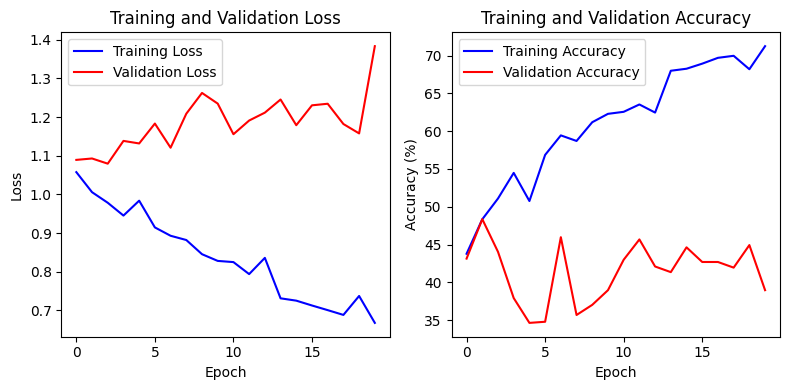

RuntimeError: Parent directory /content/gdrive/MyDrive does not exist.

In [ ]:
# Define path to train and test directories of the classifier
# train directory should contain both the real real and the GAN generated images
train_dir = '/content/cervical-cancer/kaggle/classifier_gan+real'
test_dir = '/content/cervical-cancer/kaggle/labelled_test'


#Normalizing the dataset and pre-processing the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the dataset using ImageFolder and apply the transforms
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=test_dir, transform=transform)


# Define the data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Get the number of classes
num_classes = len(train_dataset.classes)

# Get the class index
class_index = 0  # Replace with the desired class index

# Get the class name corresponding to the class index
for class_index in range (num_classes):
 class_name = train_dataset.classes[class_index]
 print(class_name)


#loading pre-trained model and only last two layers weights wil be updated

AlexNet_model = models.alexnet(pretrained=True)
AlexNet_model.classifier[4] = nn.Linear(4096,1024)
AlexNet_model.classifier[6] = nn.Linear(1024,num_classes)
AlexNet_model.classifier[4].requires_grad_(True)
AlexNet_model.classifier[6].requires_grad_(True)

AlexNet_model.eval()

from tqdm.auto import tqdm
import torch

# training
def train(model, trainloader, optimizer, criterion, device):
    model.to(device)
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image, labels = image.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()

    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# validation
def validate(model, testloader, criterion, device):
    model.to(device)
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1

            image, labels = data
            image, labels = image.to(device), labels.to(device)  # move data to GPU
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc


#from utils import save_model, save_plots
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet_model.parameters(num_classes), lr=0.001, momentum=0.9)
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

# start the training
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(AlexNet_model, train_loader,
                                              optimizer, criterion,device)
    valid_epoch_loss, valid_epoch_acc = validate(AlexNet_model, val_loader,
                                                 criterion,device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

print('TRAINING COMPLETE')

# plotting results
def plot_curves(train_loss, valid_loss, train_acc, valid_acc):
    # Plot Loss Curve
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(valid_loss, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Training Accuracy', color='blue')
    plt.plot(valid_acc, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_curves(train_loss, valid_loss, train_acc, valid_acc)

torch.save(AlexNet_model.state_dict(), '/content/gdrive/MyDrive/model_classification.pth')

model = models.alexnet(pretrained=False)
model.classifier[4] = nn.Linear(4096,1024)
model.classifier[6] = nn.Linear(1024,num_classes)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/model_classification.pth'))
model.eval()


# removing last linear layer
model.classifier = nn.Sequential(*[model.classifier[i] for i in range(5)])
model.eval()

# Function to extract features from a batch of images
def extract_features(model, dataloader):
    model.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            features = model(inputs)
            all_features.append(features.squeeze().numpy())
            all_labels.append(labels.numpy())

    all_features = np.vstack(all_features)
    all_labels = np.concatenate(all_labels)

    return all_features, all_labels

X_train_features, y_train = extract_features(model, train_loader)
X_test_features, y_test = extract_features(model, val_loader)

print("X_train_features shape:", X_train_features.shape)
print("X_test_features shape:", X_test_features.shape)


def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


# Train an SVM classifier
svm_classifier = SVC(kernel='linear',C=1.0, random_state=42, verbose=False)
svm_classifier.fit(X_train_features, y_train)

# Make predictions on the training set
y_train_pred = svm_classifier.predict(X_train_features)

# Compute training accuracy
training_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", training_accuracy*100)

y_pred = svm_classifier.predict(X_test_features)
# Compute test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy*100)

plot_confusion_matrix(y_test,y_pred)
print(classification_report(y_test, y_pred))


In [ ]:
# codes added below are for additional purposes

In [ ]:
#conversion to greyscale
import os
from google.colab.patches import cv2_imshow
import cv2

#Path to the folder containing images
folder_path_type1 = "/content/224-224-cervical-cancer-screening/kaggle/additional_Type_1_v2/Type_1"
folder_path_type2 = "/content/224-224-cervical-cancer-screening/kaggle/additional_Type_2_v2/Type_2"
folder_path_type3 = "/content/224-224-cervical-cancer-screening/kaggle/additional_Type_3_v2/Type_3"

#List all files in the folder
file_list_1 = os.listdir(folder_path_type1)
file_list_2= os.listdir(folder_path_type2)
file_list_3 = os.listdir(folder_path_type3)


# Iterate over each file of type 1
for file_name in file_list_1:
    # Checking if the file is a JPG image
    if file_name.lower().endswith(".jpg"):
        # Open the image file
        image_path = os.path.join(folder_path_type1, file_name)
        image = cv2.imread(image_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        #resize the image to 20x20 pixels
        resized_gray_image = cv2.resize(gray_image, (64, 64), interpolation=cv2.INTER_LINEAR)


        # Display resized grayscale images
        cv2_imshow(resized_gray_image)

# Iterate over each file of type 2
for file_name in file_list_2:
    # Check if the file is a JPG image
    if file_name.lower().endswith(".jpg"):
        # Open the image file
        image_path = os.path.join(folder_path_type2, file_name)
        image = cv2.imread(image_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # If you want to resize the image to 20x20 pixels
        resized_gray_image = cv2.resize(gray_image, (64, 64), interpolation=cv2.INTER_LINEAR)


        # Display resized grayscale images
        cv2_imshow(resized_gray_image)

# Iterate over each file of type 3
for file_name in file_list_3:
    # Check if the file is a JPG image
    if file_name.lower().endswith(".jpg"):
        # Open the image file
        image_path = os.path.join(folder_path_type3, file_name)
        image = cv2.imread(image_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # If you want to resize the image to 20x20 pixels
        resized_gray_image = cv2.resize(gray_image, (64, 64), interpolation=cv2.INTER_LINEAR)


        # Display resized grayscale images
        cv2_imshow(resized_gray_image)

print("Images displayed.")


# Define the input folder containing the type folders
input_folder = "/content/224-224-cervical-cancer-screening/kaggle/train/train"

# Define the output folder for grayscale images
output_folder = "grayscale_images"
os.makedirs(output_folder, exist_ok=True)  # Create the output folder if it doesn't exist

# List all type folders in the input folder
type_folders = ["Type_1", "Type_2", "Type_3"]

# Iterate over each type folder
for type_folder in type_folders:
    # List all files in the current type folder
    file_list = os.listdir(os.path.join(input_folder, type_folder))

    # Iterate over each file in the current type folder
    for file_name in file_list:
        # Check if the file is a JPG image
        if file_name.lower().endswith(".jpg"):
            # Open the image file
            image_path = os.path.join(input_folder, type_folder, file_name)
            image = cv2.imread(image_path)

            # Convert the image to grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Save the grayscale image in the output folder
            output_image_path = os.path.join(output_folder, f"{type_folder}_grayscale", "grayscale_" + file_name)
            os.makedirs(os.path.dirname(output_image_path), exist_ok=True)  # Create the output folder if it doesn't exist
            cv2.imwrite(output_image_path, gray_image)

print("Grayscale images saved in the output folder.")


In [ ]:
#get image dimensions
from PIL import Image

def get_image_dimensions(image_path):
    # Open the image file
    image = Image.open(image_path)

    # Get the dimensions of the image
    width, height = image.size

    # Close the image file
    image.close()

    return width, height

# Example usage:
image_path = '/content/grayscale_images/Type_1_grayscale/grayscale_0.jpg'  # Replace this with the path to your JPEG image
width, height = get_image_dimensions(image_path)
print("Image dimensions:", width, "x", height)

In [ ]:
# creating labelled test images

import os
import shutil
import random

# Function to create test data folder with randomly selected labeled images
def create_test_data(source_dirs, test_data_dir, num_samples):
    # Create the test data directory if it doesn't exist
    if not os.path.exists(test_data_dir):
        os.makedirs(test_data_dir)

    # Iterate through each source directory
    for class_dir, num_samples_per_class in zip(source_dirs, num_samples):
        class_name = os.path.basename(class_dir)

        # Get list of image files in the current class directory
        image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

        # Randomly sample the required number of images
        sampled_images = random.sample(image_files, min(num_samples_per_class, len(image_files)))

        # Copy each sampled image to the test data directory with the desired format
        for idx, image_file in enumerate(sampled_images):
            source_path = os.path.join(class_dir, image_file)
            dest_filename = f"{class_name}_{idx}.jpg"
            dest_path = os.path.join(test_data_dir, dest_filename)
            shutil.copyfile(source_path, dest_path)

# Directories containing type 1, type 2, and type 3 images
type1_dir = "path/to/type1_images"
type2_dir = "path/to/type2_images"
type3_dir = "path/to/type3_images"

# Directory for the test data
test_data_dir = "path/to/test_data"

# Number of images to randomly select from each directory
num_samples = [200, 350, 120]

# Create test data folder with randomly selected labeled images
create_test_data([type1_dir, type2_dir, type3_dir], test_data_dir, num_samples)

In [ ]:
# Moving files from one folder to another

import os
from PIL import Image

def grayscale_images(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each file in the input folder
    for filename in os.listdir(input_folder):
        # Check if the file is an image (you can add more image extensions if needed)
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            # Open the image
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)

            # Convert the image to grayscale
            grayscale_img = img.convert('L')

            # Save the grayscale image to the output folder
            output_path = os.path.join(output_folder, filename)
            grayscale_img.save(output_path)

            print(f"{filename} converted to grayscale and saved as {output_path}")

# Call the function to grayscale images
input_folder = '/content/cervical-cancer-grey-scaled/kaggle/test/test'
output_folder = '/content/cervical-cancer-grey-scaled/kaggle/test_gs'
grayscale_images(input_folder, output_folder)


In [ ]:
#downloading images

# Define the path to the directory containing the images to be downloaded
output_folder = '/content/224-224-cervical-cancer-screening/op'

zip_destination = '/content/downloaded_images.zip'

# Zip the images
shutil.make_archive('/content/downloaded_images', 'zip', output_folder)

# Move the zip file to the specified destination
shutil.move('/content/downloaded_images.zip', zip_destination)

print("images zipped and saved as downloaded_images.zip")

from google.colab import files

# Download the zip file to local system
files.download('/content/downloaded_images.zip')



In [ ]:
#clearing out progress. keep it commented

# def remove_all_folders(root_dir):
#     # Iterate over all items in the root directory
#     for item in os.listdir(root_dir):
#         item_path = os.path.join(root_dir, item)

#         # Check if the item is a directory
#         if os.path.isdir(item_path):
#             # print(f"Removing folder: {item_path}")

#             # Use shutil.rmtree() to remove the folder recursively
#             shutil.rmtree(item_path)

# # Specify the root directory from which you want to remove all folders
# root_directory = '/content/'

# # Call the remove_all_folders() function with the root directory
# remove_all_folders(root_directory)
